In [ ]:
from google.colab import drive
import os
import shutil

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install timm torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import timm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
min_samples = 4
data_dir = '/content/drive/MyDrive/writerbinary'
writer_folders = os.listdir(data_dir)

writers_to_remove = []
for writer in writer_folders:
    writer_path = os.path.join(data_dir, writer)
    if os.path.isdir(writer_path):
        num_images = len([f for f in os.listdir(writer_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if num_images < min_samples:
            writers_to_remove.append((writer, num_images))

print("Writers with fewer than 4 samples:")
for writer, count in writers_to_remove:
    print(f"{writer}: {count} samples")

# Delete folders with < 4 samples
for writer, _ in writers_to_remove:
    writer_path = os.path.join(data_dir, writer)
    shutil.rmtree(writer_path)
    print(f"Deleted: {writer_path}")



Writers with fewer than 4 samples:


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=5, translate=(0.02, 0.02)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)


In [ ]:
val_split = 0.2
val_size = int(len(dataset) * val_split)
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)

num_classes = len(dataset.classes)
print(f"Final number of writer classes: {num_classes}")



Final number of writer classes: 509


In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super().__init__()
        self.s = s
        self.m = m
        self.fc = nn.Parameter(torch.Tensor(out_features, in_features))
        nn.init.xavier_uniform_(self.fc)

    def forward(self, embeddings, labels):
        W = F.normalize(self.fc)
        x = F.normalize(embeddings)
        cosine = F.linear(x, W)
        theta = torch.acos(torch.clamp(cosine, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = torch.cos(theta + self.m)
        one_hot = F.one_hot(labels, num_classes=W.size(0)).float().to(x.device)
        logits = cosine * (1 - one_hot) + target_logits * one_hot
        return self.s * logits


In [ ]:
class WriterIDModel(nn.Module):
    def __init__(self, backbone_name='resnet50', embedding_size=128, num_classes=510):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        in_features = self.backbone.num_features
        self.embedding = nn.Linear(in_features, embedding_size)
        self.arcface = ArcFace(embedding_size, num_classes)

    def forward(self, x, labels=None):
        x = self.backbone(x)
        x = F.normalize(self.embedding(x))
        if labels is not None:
            logits = self.arcface(x, labels)
            return logits
        return x

In [ ]:
model = WriterIDModel(num_classes=num_classes).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [ ]:
epochs = 20
train_accuracies = []
val_accuracies = []
loss=[]

for epoch in range(epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        logits = model(imgs, labels)
        loss = F.cross_entropy(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (logits.argmax(1) == labels).sum().item()
        total += labels.size(0)

    acc = correct / total

    # Validation phase
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            logits = model(imgs, labels)
            val_correct += (logits.argmax(1) == labels).sum().item()
            val_total += labels.size(0)
    val_acc = val_correct / val_total
    train_accuracies.append(acc)
    val_accuracies.append(val_acc)
    loss.append(total_loss)
    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Train Acc: {acc:.4f} | Val Acc: {val_acc:.4f}")


[Epoch 1] Loss: 3.9809 | Train Acc: 0.3522 | Val Acc: 0.1904
[Epoch 2] Loss: 1.0723 | Train Acc: 0.4181 | Val Acc: 0.3333
[Epoch 3] Loss: .9100 | Train Acc: 0.4554 | Val Acc: 0.4252
[Epoch 4] Loss: 0.6510 | Train Acc: 0.5223 | Val Acc: 0.4932
[Epoch 5] Loss: 0.6485 | Train Acc: 0.5703 | Val Acc: 0.5291
[Epoch 6] Loss: 0.4005 | Train Acc: 0.6221 | Val Acc: 0.5591
[Epoch 7] Loss: .4106 | Train Acc: 0.6672 | Val Acc: 0.6423
[Epoch 8] Loss: 0.3002 | Train Acc: 0.7006 | Val Acc: 0.6921
[Epoch 9] Loss: 0.3023 | Train Acc: 0.7456 | Val Acc: 0.7103
[Epoch 10] Loss: 0.2034 | Train Acc: 0.7737 | Val Acc: 0.7301
[Epoch 11] Loss: 0.1609 | Train Acc: 0.7970 | Val Acc: 0.7601
[Epoch 12] Loss: 0.0693 | Train Acc: 0.8319 | Val Acc: 0.8010
[Epoch 13] Loss: 0.0702 | Train Acc: 0.8634 | Val Acc: 0.8422
[Epoch 14] Loss: 0.0508 | Train Acc: 0.8760 | Val Acc: 0.8621
[Epoch 15] Loss: 0.0408 | Train Acc: 0.9079 | Val Acc: 0.8922
[Epoch 16] Loss: 0.0365 | Train Acc: 0.9026 | Val Acc: 0.8992
[Epoch 17] Loss: 0.

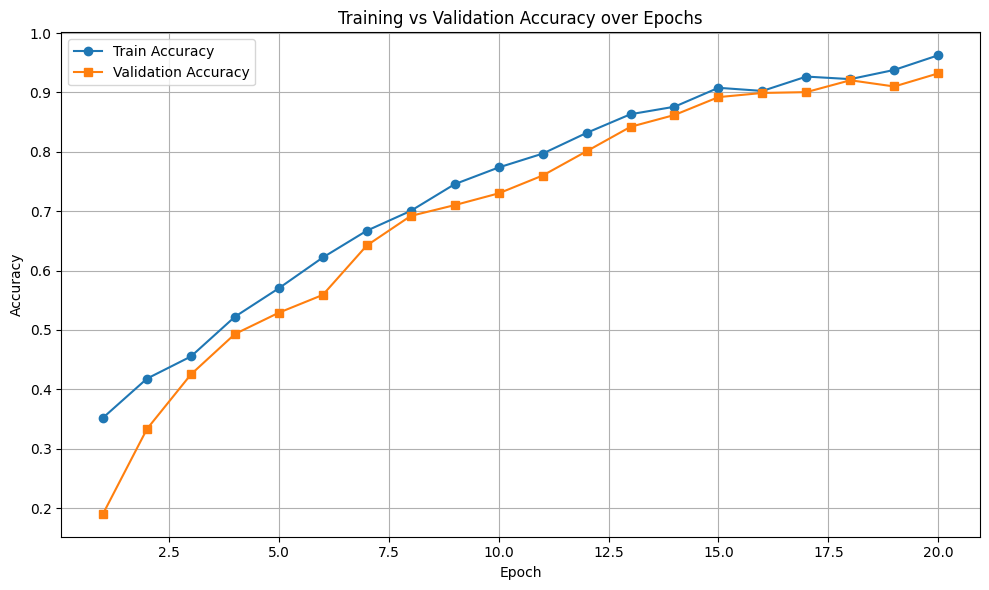

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


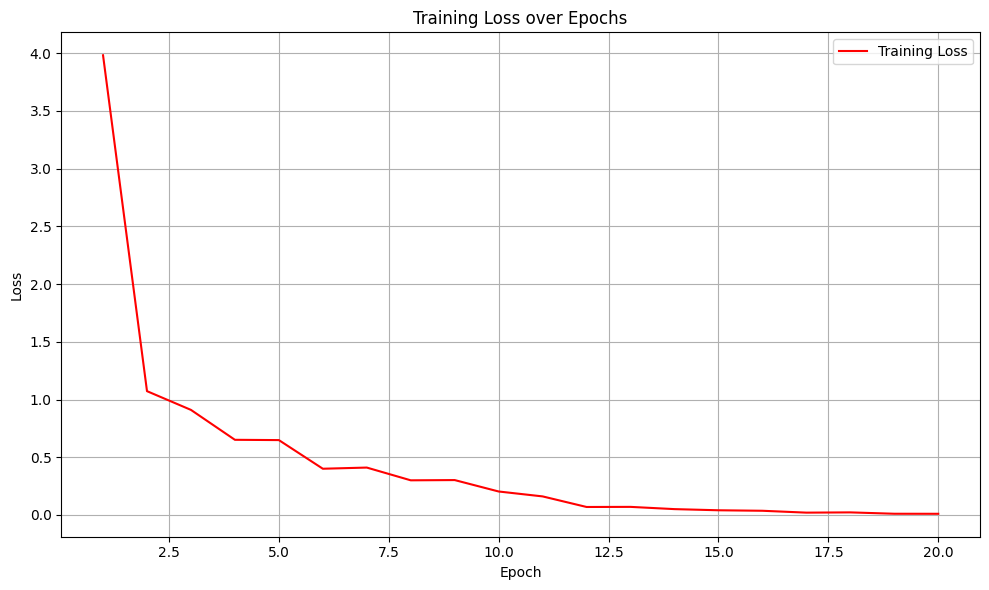

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1),loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


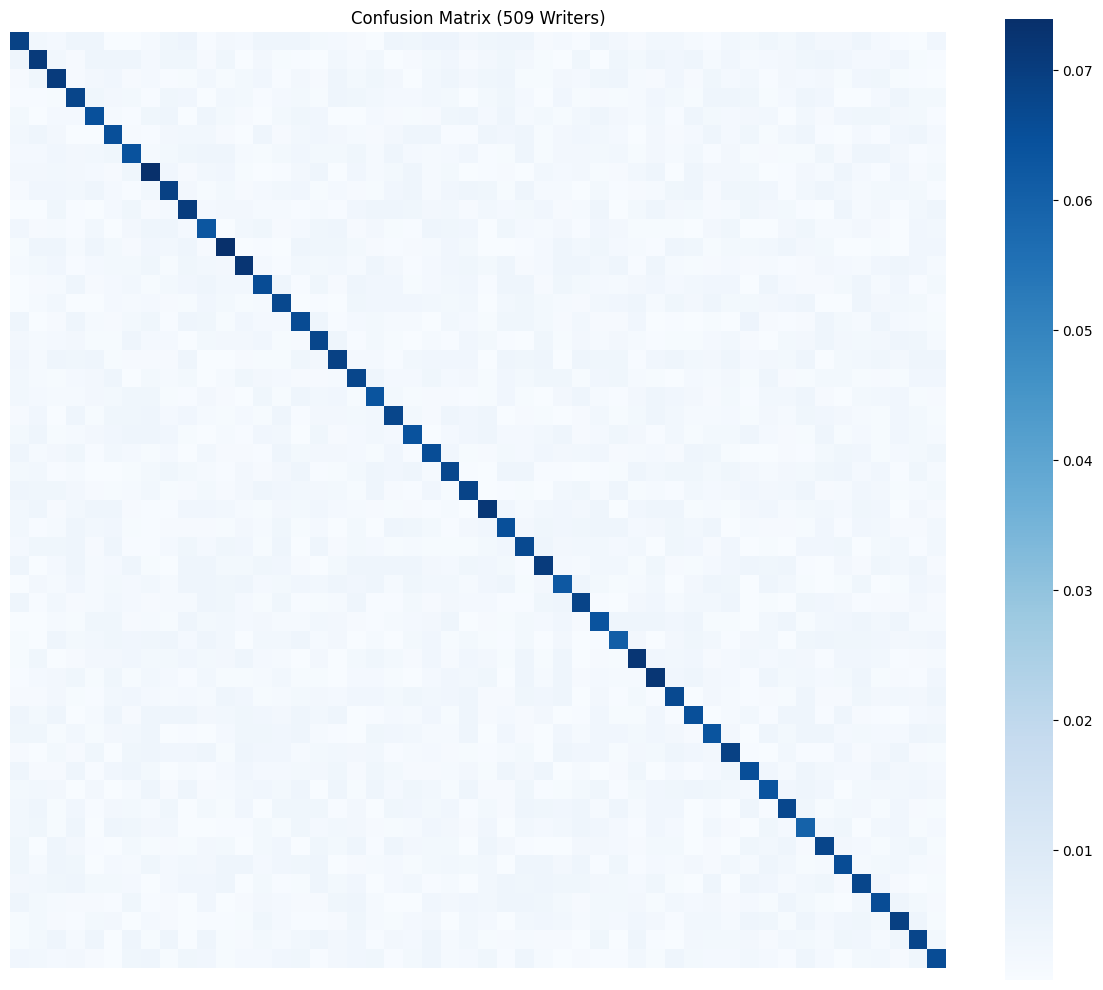

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_true = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(labels.numpy())

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
plt.figure(figsize=(10, 10))
disp.plot(include_values=False, cmap='Blues', xticks_rotation='vertical')
plt.title("Confusion Matrix (509 Writers)")
plt.tight_layout()
plt.show()



In [ ]:
model_path = "/content/drive/MyDrive/arcface_writer_model.pth"
torch.save(model.state_dict(), model_path)
